In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from glob import glob
import numpy as np
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Dropout, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as keras
from sklearn.metrics import confusion_matrix
import seaborn as sns
from skimage import color
from tensorflow.keras.utils import plot_model


SRC = '/content/drive/MyDrive/datasets/lung/'

IMAGE_DIR = '/content/drive/MyDrive/datasets/lung/CXR_png/'
LEFT_MASK_DIR = '/content/drive/MyDrive/datasets/lung/ManualMask/leftMask/'
RIGHT_MASK_DIR ='/content/drive/MyDrive/datasets/lung/ManualMask/rightMask/'
MASK_DIR = '/content/drive/MyDrive/datasets/lung/ManualMask/Mask/'
IMAGES = '/content/drive/MyDrive/datasets/lung/Images/'

In [ ]:
!pip install tqdm

ERROR: Could not find a version that satisfies the requirement glob (from versions: none)
ERROR: No matching distribution found for glob


In [ ]:
DILATE_KERNEL = np.ones((15, 15), np.uint8)
EPOCHS = 50
BATCH_SIZE=2
montgomery_left_mask_dir = glob(os.path.join(LEFT_MASK_DIR, '*.png'))
montgomery_test = montgomery_left_mask_dir[0:50]
montgomery_train= montgomery_left_mask_dir[50:]


for left_image_file in tqdm(montgomery_left_mask_dir):
    base_file = os.path.basename(left_image_file)
    image_file = os.path.join(IMAGE_DIR, base_file)
    right_image_file = os.path.join(RIGHT_MASK_DIR, base_file)

    image = cv2.imread(image_file)
    left_mask = cv2.imread(left_image_file, cv2.IMREAD_GRAYSCALE)
    right_mask = cv2.imread(right_image_file, cv2.IMREAD_GRAYSCALE)

    image = cv2.resize(image, (512, 512))
    left_mask = cv2.resize(left_mask, (512, 512))
    right_mask = cv2.resize(right_mask, (512, 512))

    mask = np.maximum(left_mask, right_mask)
    mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)
    cv2.imwrite(os.path.join(MASK_DIR, base_file), mask)
    cv2.imwrite(os.path.join(IMAGES, base_file),image)

100%|██████████| 138/138 [04:38<00:00,  2.01s/it]


In [ ]:
EPOCHS = 50
BATCH_SIZE=2
IMAGE_SIZE = (512, 512)

mask_files = glob(os.path.join(MASK_DIR, '*.png'))
image_files = glob(os.path.join(IMAGES, '*.png'))

image_files_train, image_files_temp, mask_files_train, mask_files_temp = train_test_split(image_files, mask_files, test_size=0.3, random_state=42)
image_files_val, image_files_test, mask_files_val, mask_files_test = train_test_split(image_files_temp, mask_files_temp, test_size=0.5, random_state=42)

def data_generator(image_files, mask_files, batch_size=BATCH_SIZE, shuffle=True):
    while True:
        if shuffle:
            indices = np.random.permutation(len(image_files))
            image_files = [image_files[i] for i in indices]
            mask_files = [mask_files[i] for i in indices]
        for i in range(0, len(image_files), batch_size):
            batch_image_files = image_files[i:i + batch_size]
            batch_mask_files = mask_files[i:i + batch_size]
            images = []
            masks = []
            for image_file, mask_file in zip(batch_image_files, batch_mask_files):
                image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
                mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
                image = cv2.resize(image, IMAGE_SIZE)
                mask = cv2.resize(mask, IMAGE_SIZE)
                image = image / 255.0
                mask = mask / 255.0
                mask = (mask > 0).astype(np.float32)
                images.append(np.expand_dims(image, axis=-1))
                masks.append(mask)
            yield np.array(images), np.array(masks)

train_generator = data_generator(image_files_train, mask_files_train)
val_generator = data_generator(image_files_val, mask_files_val)

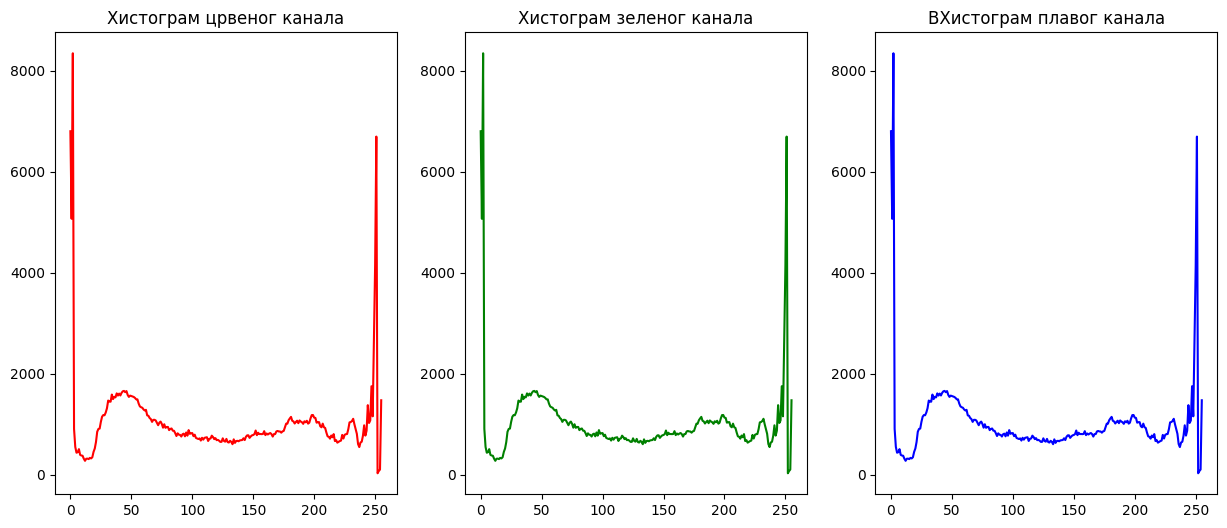

In [ ]:
def plot_color_histogram(image):
    hist_r = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist_g = cv2.calcHist([image], [1], None, [256], [0, 256])
    hist_b = cv2.calcHist([image], [2], None, [256], [0, 256])

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 3, 1)
    plt.plot(hist_r, color='red')
    plt.title('Хистограм црвеног канала')

    plt.subplot(1, 3, 2)
    plt.plot(hist_g, color='green')
    plt.title('Хистограм зеленог канала')

    plt.subplot(1, 3, 3)
    plt.plot(hist_b, color='blue')
    plt.title('BХистограм плавог канала')

    plt.show()

sample_index = np.random.randint(0, len(image_files_train))
sample_image = cv2.imread(image_files_train[sample_index])
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

plot_color_histogram(sample_image)

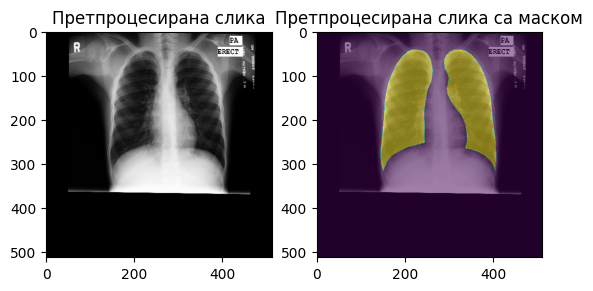

In [ ]:
sample_images, sample_masks = next(train_generator)

sample_index = np.random.randint(0, len(sample_images))

plt.subplot(1, 2, 1)
plt.imshow(sample_images[sample_index].squeeze(), cmap='gray')
plt.title('Претпроцесирана слика')

plt.subplot(1, 2, 2)
plt.imshow(sample_images[sample_index].squeeze(), cmap='gray')
plt.imshow(sample_masks[sample_index].squeeze(), alpha=0.5)
plt.title('Претпроцесирана слика са маском')

plt.show()

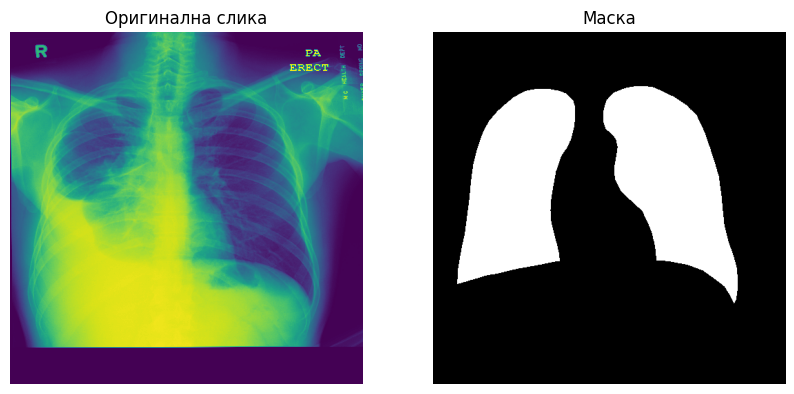

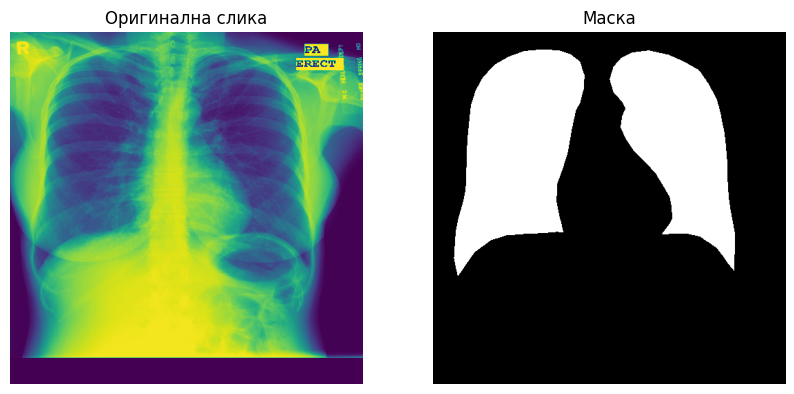

In [ ]:
def display_images_and_masks(image_files, mask_files, generator, num_batches=1):
    for _ in range(num_batches):
        images, masks = next(generator)
        for i in range(images.shape[0]):
            image = images[i]
            mask = masks[i]

            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(image)
            plt.title('Оригинална слика')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(mask, cmap='gray')
            plt.title('Маска')
            plt.axis('off')

            plt.show()

display_images_and_masks(image_files_train, mask_files_train, train_generator)

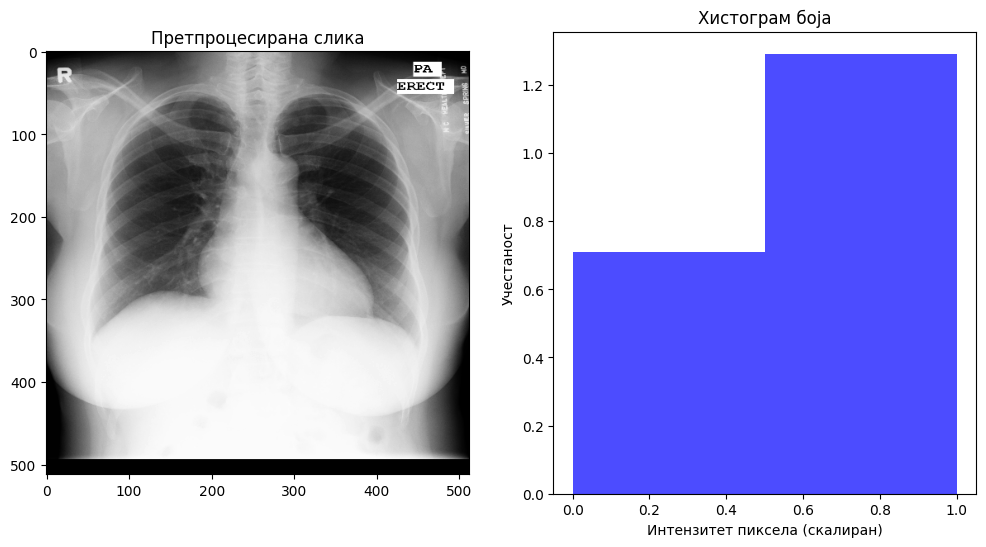

In [ ]:
test_images, test_masks = next(test_generator)
sample_index = np.random.randint(0, len(test_images))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(test_images[sample_index].squeeze(), cmap='gray')
plt.title('Претпроцесирана слика')

plt.subplot(1, 2, 2)
plt.hist(test_images[sample_index].ravel(), bins=2, range=(0, 1), density=True, color='blue', alpha=0.7)
plt.title('Хистограм боја')
plt.xlabel('Интензитет пиксела (скалиран)')
plt.ylabel('Учестаност')
plt.show()

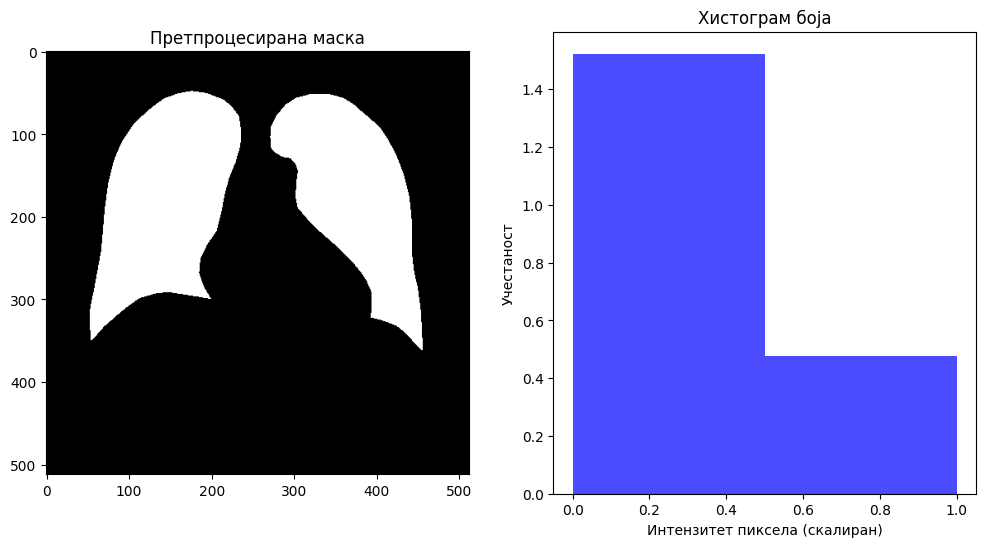

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(test_masks[sample_index].squeeze(), cmap='gray')
plt.title('Претпроцесирана маска')

plt.subplot(1, 2, 2)
plt.hist(test_masks[sample_index].ravel(), bins=2, range=(0, 1), density=True, color='blue', alpha=0.7)
plt.title('Хистограм боја')
plt.xlabel('Интензитет пиксела (скалиран)')
plt.ylabel('Учестаност')
plt.show()

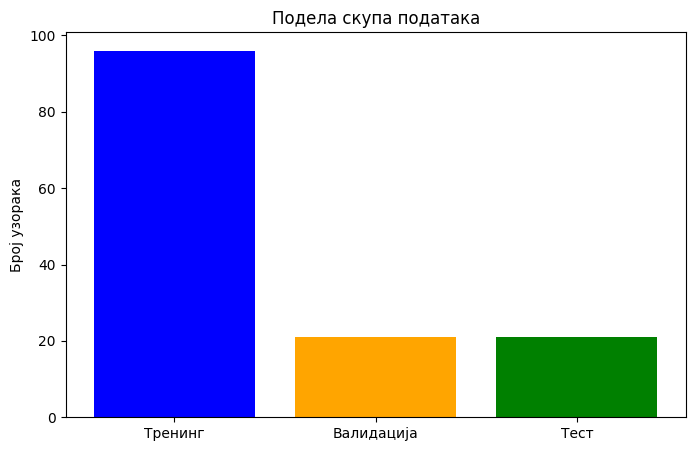

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


split_sizes = [len(image_files_train), len(image_files_val), len(image_files_test)]
labels = ['Тренинг', 'Валидација', 'Тест']

plt.figure(figsize=(8, 5))
plt.bar(labels, split_sizes, color=['blue', 'orange', 'green'])
plt.title('Подела скупа података')
plt.ylabel('Број узорака')
plt.show()

In [ ]:
def unet(input_size=(512,512,1)):
    inputs = Input(input_size)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])


In [ ]:
images, masks = next(train_generator)
image = images[0]
image.shape

(512, 512, 1)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 512, 512, 32)         320       ['input_3[0][0]']             
                                                                                                  
 conv2d_39 (Conv2D)          (None, 512, 512, 32)         9248      ['conv2d_38[0][0]']           
                                                                                                  
 max_pooling2d_8 (MaxPoolin  (None, 256, 256, 32)         0         ['conv2d_39[0][0]']           
 g2D)                                                                                       

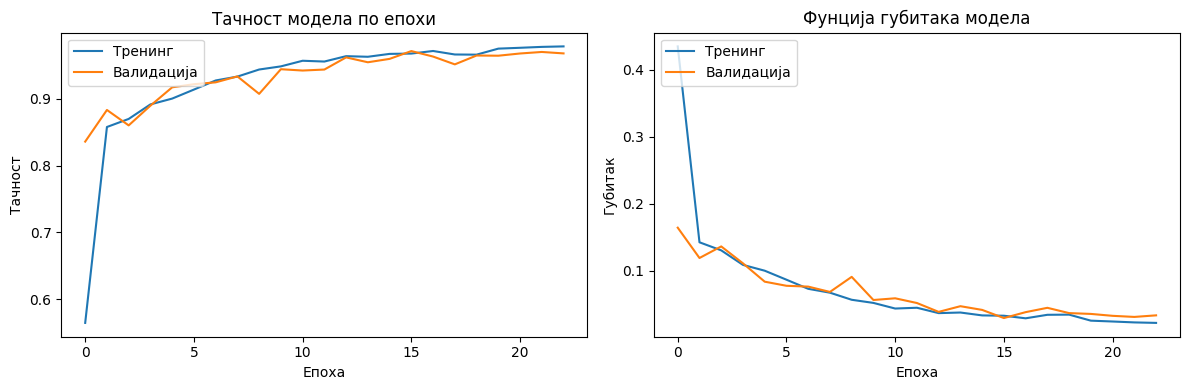

In [ ]:
model = unet()
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, \
                  metrics=[dice_coef, 'binary_accuracy'])

model.summary()

checkpoint = ModelCheckpoint('unet_model_v2.keras', monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(train_generator, steps_per_epoch=len(image_files_train)//BATCH_SIZE,
                              epochs=30, validation_data=val_generator,
                              validation_steps=len(image_files_val)//BATCH_SIZE,
                              callbacks=[checkpoint, early_stopping, reduce_lr])

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Тачност модела по епохи')
plt.xlabel('Епоха')
plt.ylabel('Тачност')
plt.legend(['Тренинг', 'Валидација'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Фунција губитака модела')
plt.xlabel('Епоха')
plt.ylabel('Губитак')
plt.legend(['Тренинг', 'Валидација'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
model = tf.keras.models.load_model('unet_model_v2.keras', custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})

test_generator = data_generator(image_files_test, mask_files_test, shuffle=False)
test_images, test_masks = next(test_generator)

predicted_masks = model.predict(test_images)


1/1 [==============================] - 0s 384ms/step


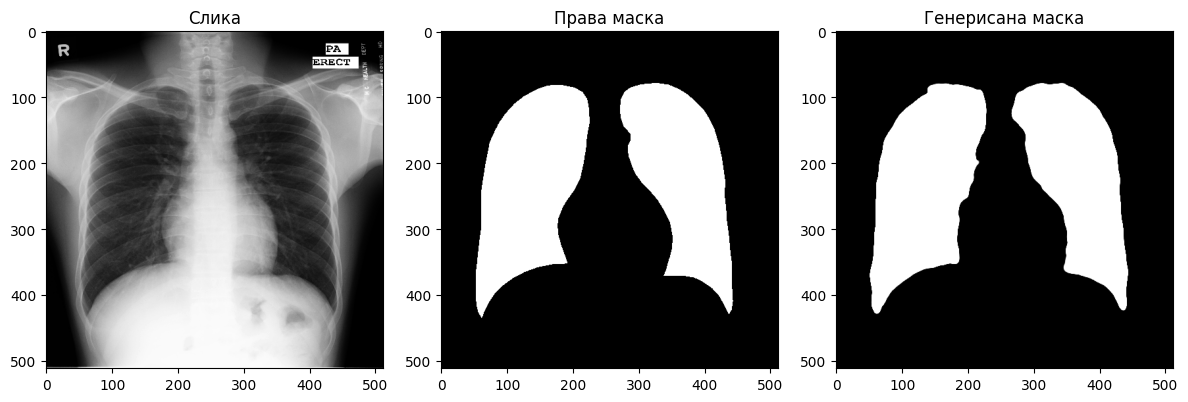

10/10 [==============================] - 1s 51ms/step - loss: 0.0272 - dice_coef: 0.9714 - binary_accuracy: 0.9859
Test Dice Coefficient: 0.9714
Test Binary Accuracy: 0.9859


In [ ]:
sample_index = np.random.randint(0, len(test_images))

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(test_images[sample_index].squeeze(), cmap='gray')
plt.title('Слика')

plt.subplot(1, 3, 2)
plt.imshow(test_masks[sample_index].squeeze(), cmap='gray')
plt.title('Права маска')

plt.subplot(1, 3, 3)
plt.imshow(predicted_masks[sample_index].squeeze(), cmap='gray')
plt.title('Генерисана маска')

plt.tight_layout()
plt.show()


evaluation = model.evaluate(test_generator, steps=len(image_files_test)//BATCH_SIZE)
print(f"Test Dice Coefficient: {evaluation[1]:.4f}")
print(f"Test Binary Accuracy: {evaluation[2]:.4f}")

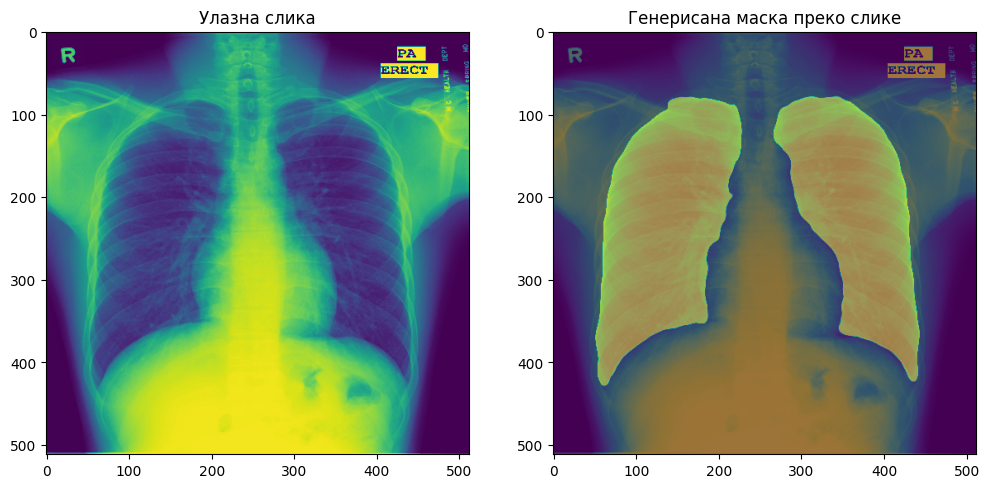

In [ ]:
predicted_masks_gray = (predicted_masks.squeeze() * 255).astype(np.uint8)

sample_index = np.random.randint(0, len(test_images))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(test_images[sample_index].squeeze())
plt.title('Улазна слика')

plt.subplot(1, 2, 2)
plt.imshow(test_images[sample_index].squeeze())
plt.imshow(predicted_masks_gray[sample_index], alpha=0.5)
plt.title('Генерисана маска преко слике')
plt.show()

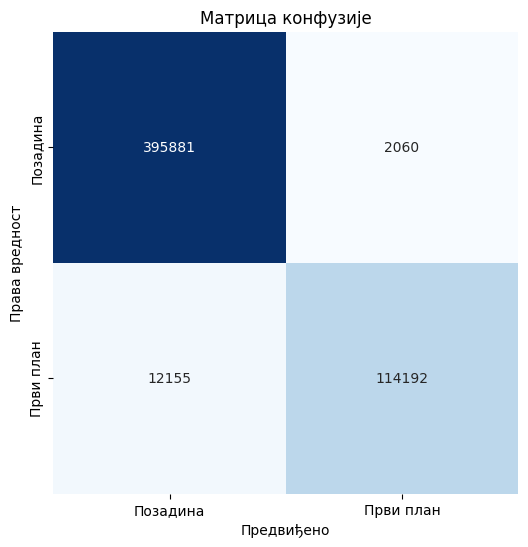

In [ ]:
true_masks_flat = test_masks.flatten()
predicted_masks_flat = (predicted_masks > 0.5).astype(np.float32).flatten()

cm = confusion_matrix(true_masks_flat, predicted_masks_flat)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Позадина', 'Први план'],
            yticklabels=['Позадина', 'Први план'])
plt.title('Матрица конфузије')
plt.xlabel('Предвиђено')
plt.ylabel('Права вредност')
plt.show()

['conv2d_741', 'conv2d_742', 'conv2d_743', 'conv2d_744', 'conv2d_745', 'conv2d_746', 'conv2d_747', 'conv2d_748', 'conv2d_749', 'conv2d_750', 'conv2d_751', 'conv2d_752', 'conv2d_753', 'conv2d_754', 'conv2d_755', 'conv2d_756', 'conv2d_757', 'conv2d_758', 'conv2d_759']
1/1 [==============================] - 0s 347ms/step


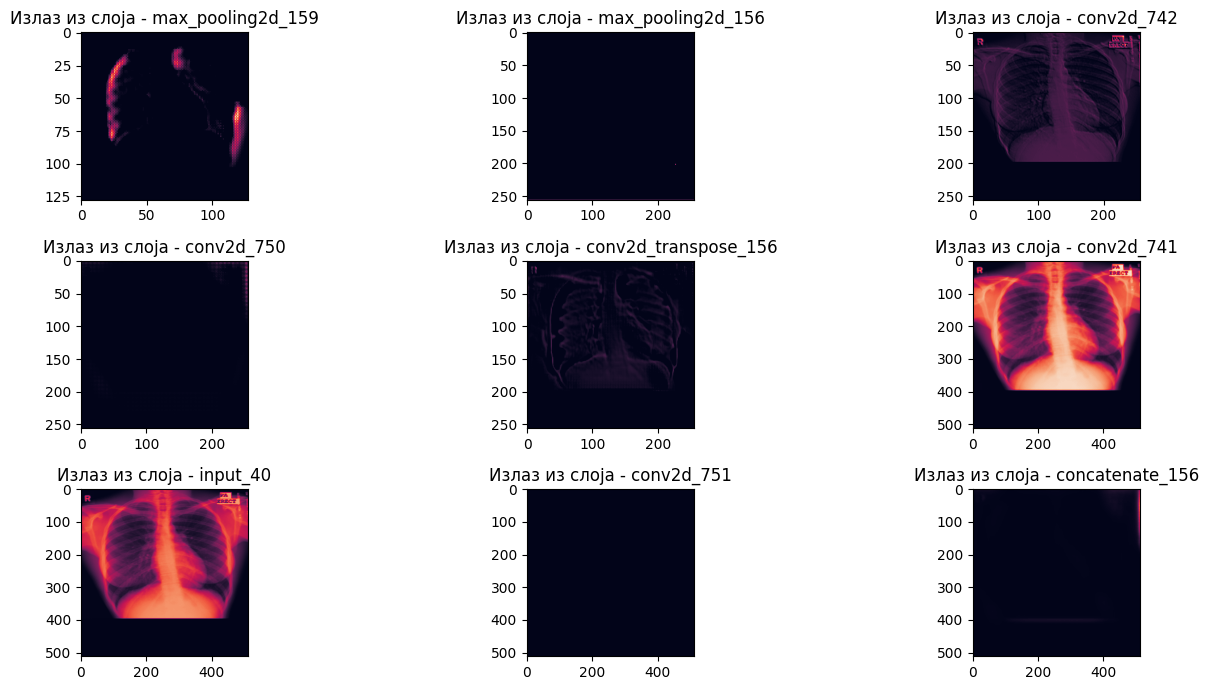

In [ ]:
del model

model = unet()
model.load_weights('unet_model_v2.keras')
sample_index = np.random.randint(0, len(image_files_val))
sample_image = cv2.imread(image_files_val[sample_index], cv2.IMREAD_GRAYSCALE)
sample_image = cv2.resize(sample_image, (512, 512))

layer_names = [layer.name for layer in model.layers]
conv_layer_names = [name for name in layer_names if 'conv2d' in name.lower() and 'transpose' not in name.lower()]
print(conv_layer_names)
selected_layers = conv_layer_names

activation_model = tf.keras.models.Model(inputs=model.input, outputs=[model.get_layer(layer_name).output for layer_name in selected_layers])

activations = activation_model.predict(np.expand_dims(sample_image, axis=0))

num_bright_pixels = [np.sum(activation_map > 0.5) for activation_map in activations]
top_activations_indices = np.argsort(num_bright_pixels)[-9:]

plt.figure(figsize=(15, 7))
for i, activation_map_index in enumerate(top_activations_indices):
    activation_map = activations[activation_map_index][0, :, :, 0]
    plt.subplot(3, 3, i+1)
    plt.imshow(activation_map, cmap='rocket')
    plt.title(f'Излаз из слоја - {layer_names[selected_layers.index(conv_layer_names[activation_map_index])]}')

plt.tight_layout()
plt.show()

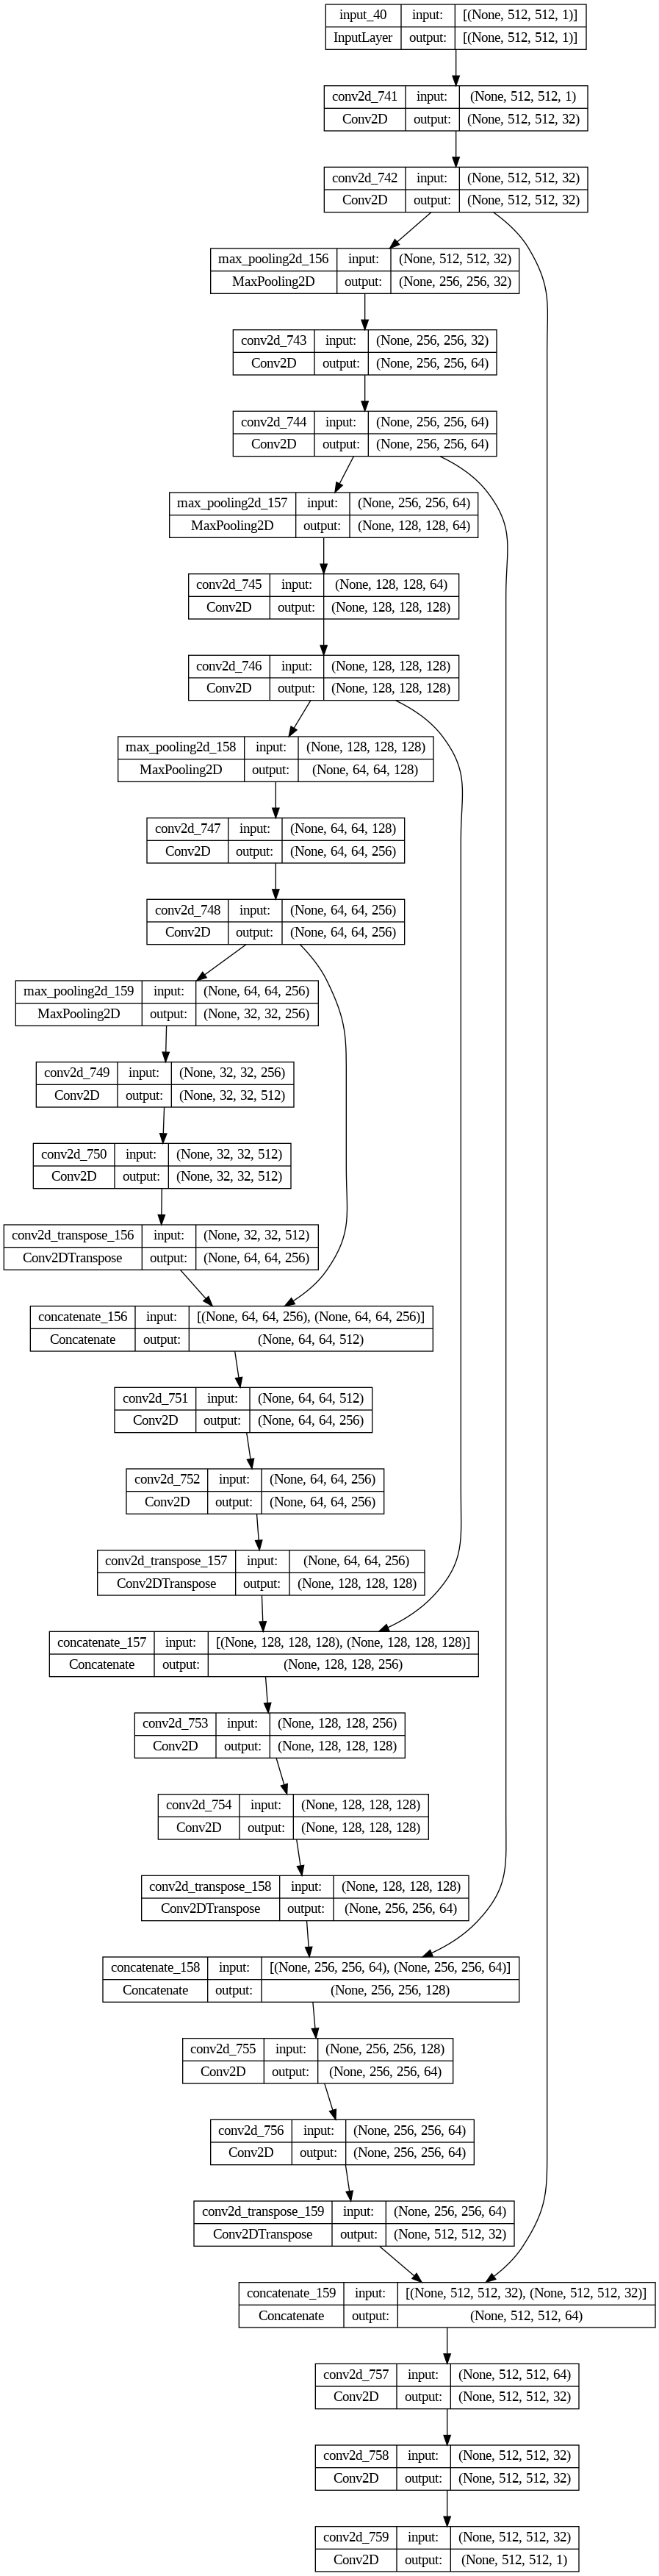

In [ ]:
plot_model(model, to_file='model_architecture.png', show_shapes=True)